In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.6
exoplanet version: 0.1.4dev0


# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

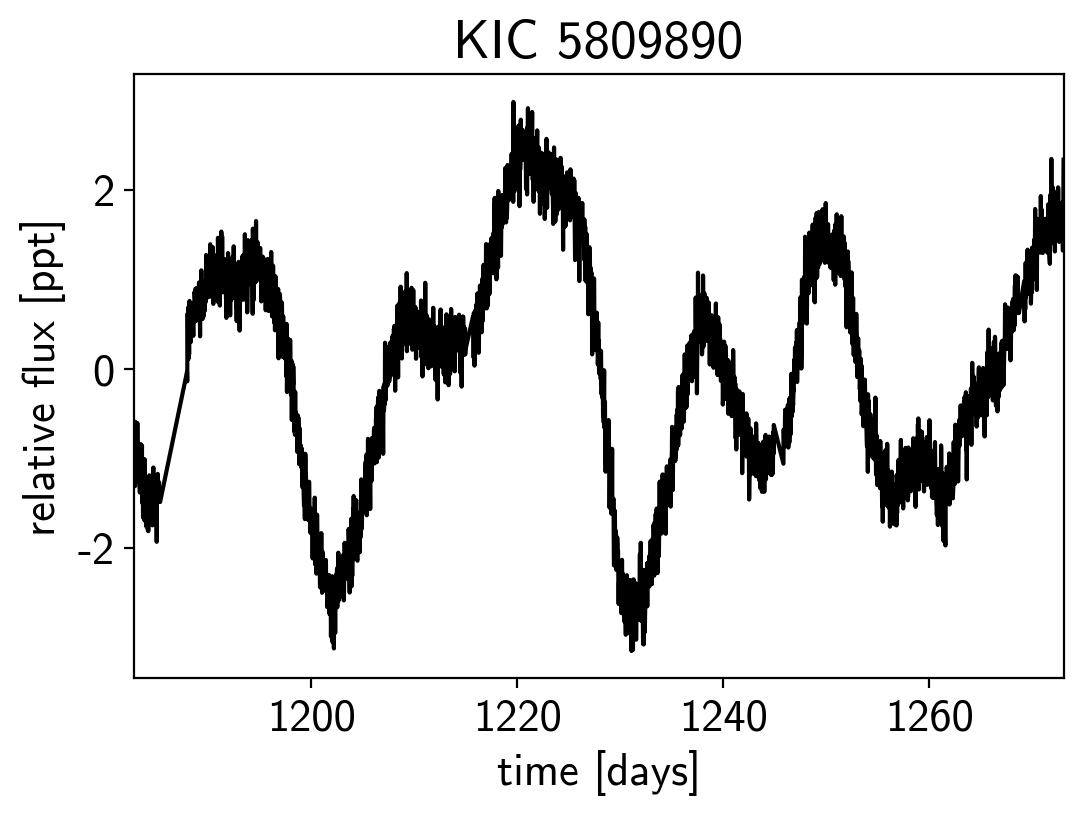

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    
x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

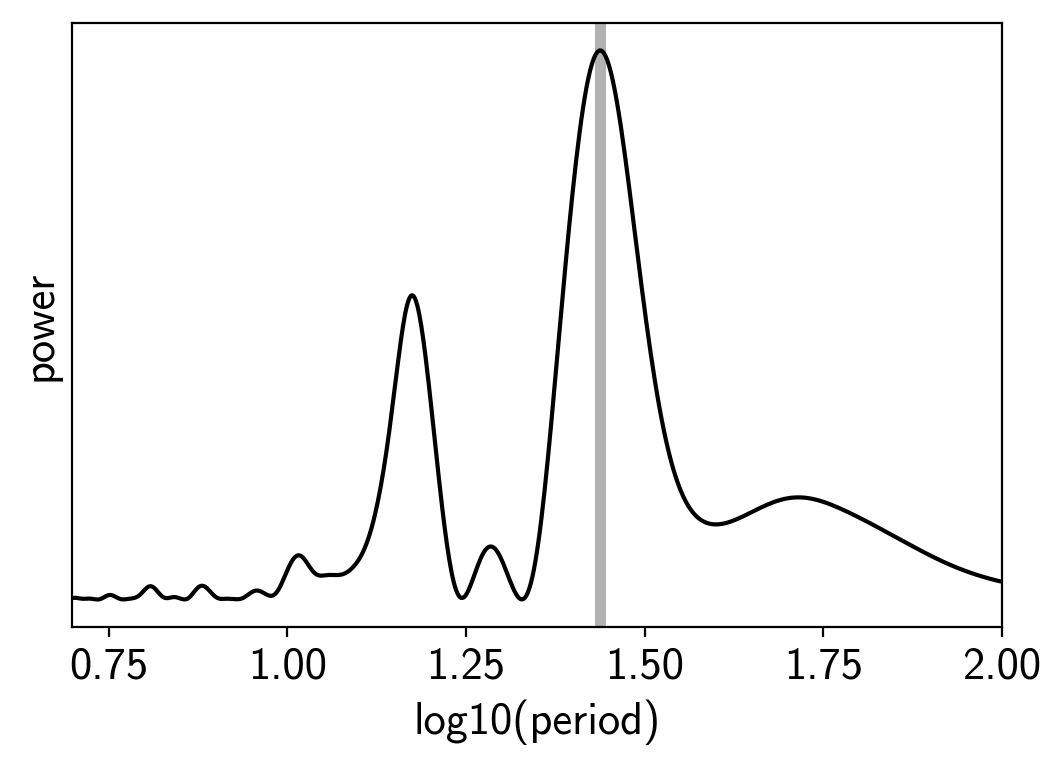

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

success: False
initial logp: 509.6137787810301
final logp: 692.9546941343863


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

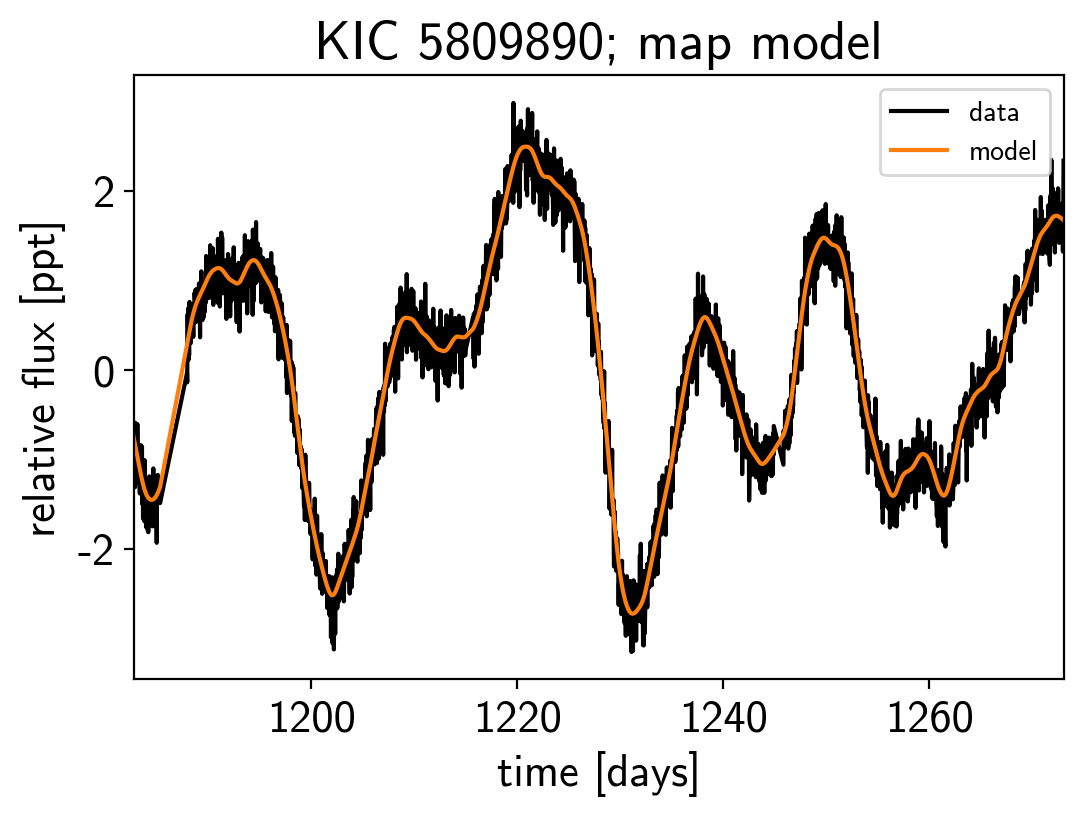

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [10]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains: 100%|██████████| 808/808 [00:11<00:00, 68.76draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:06<00:00, 63.42draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [11]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.601516,0.247680,0.005211,0.173163,0.999673,2188.133657,1.000208
logdeltaQ,1.267122,9.666064,0.163315,-17.571933,21.396943,3052.091411,1.000281
logQ0,0.648708,0.617904,0.011721,-0.475672,1.924404,2749.453585,1.000996
logperiod,3.369179,0.136643,0.003117,3.160408,3.628902,1694.432289,1.000428
logamp,-0.043794,0.602286,0.011902,-1.090223,1.150858,2484.857126,1.001070
logs2,-4.970013,0.125885,0.001783,-5.211133,-4.723204,5113.124012,1.000799
mean,-0.020826,0.218111,0.004171,-0.411375,0.447832,2702.979747,1.000351


And plot the posterior distribution over rotation period:

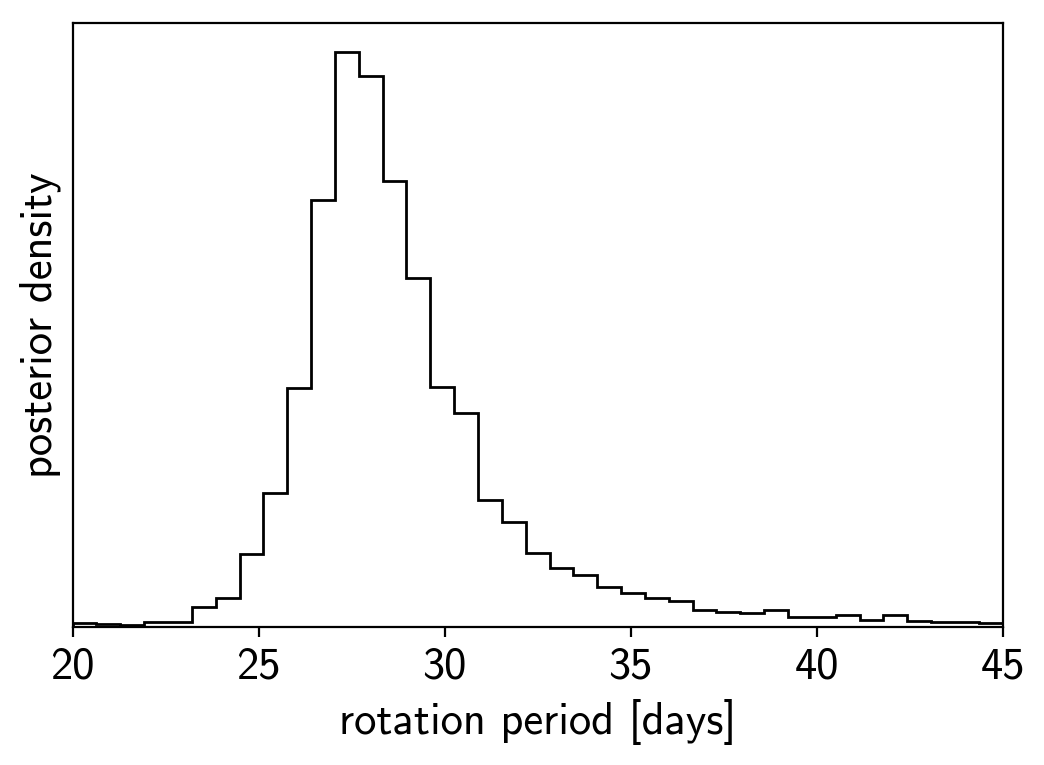

In [12]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");